In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,6

import warnings
warnings.filterwarnings('ignore')

In [2]:
path='D://SimpliLearn Projects//Machine Learning//Demo Datasets//Lesson 8//'
df = pd.read_csv(path+'monthly-beer-production-in-austr.csv')
df.head()

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
df.shape

(476, 2)

In [4]:
df['Month'] = df['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))
df = df.set_index('Month')
df.head()

,Monthly beer production in Australia
Month,
1956-01-15,93.2
1956-02-15,96.0
1956-03-15,95.2
1956-04-15,77.1
1956-05-15,70.9


In [5]:
ts = df['Monthly beer production in Australia']

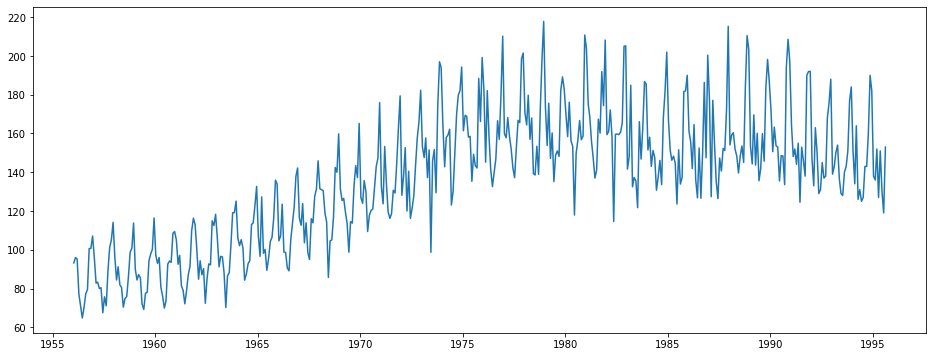

In [6]:
plt.plot(ts)

In [7]:
ts_log = np.log(ts)

In [8]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='orange', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean & std')
    plt.show(block=False)
    
    print('Result of Dickey - Fuller')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Legs Used', 'Number of Observation Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

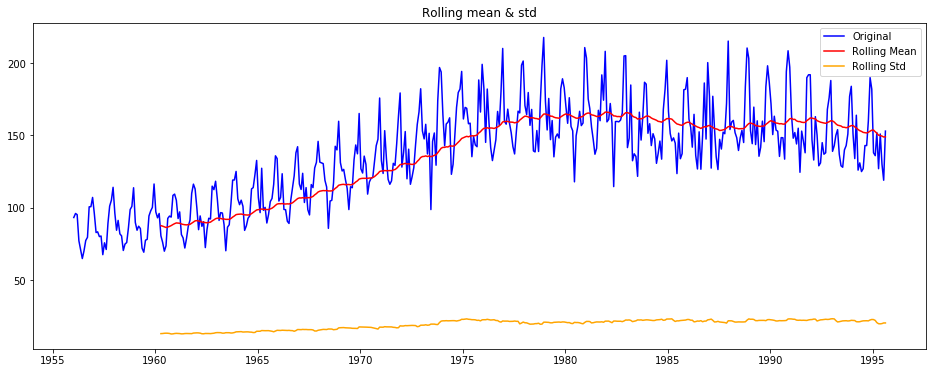

Result of Dickey - Fuller
Test Statistic                 -2.282661
p-value                         0.177621
#Legs Used                     17.000000
Number of Observation Used    458.000000
Critical Value (1%)            -3.444709
Critical Value (5%)            -2.867871
Critical Value (10%)           -2.570142
dtype: float64


In [9]:
test_stationarity(df['Monthly beer production in Australia'])

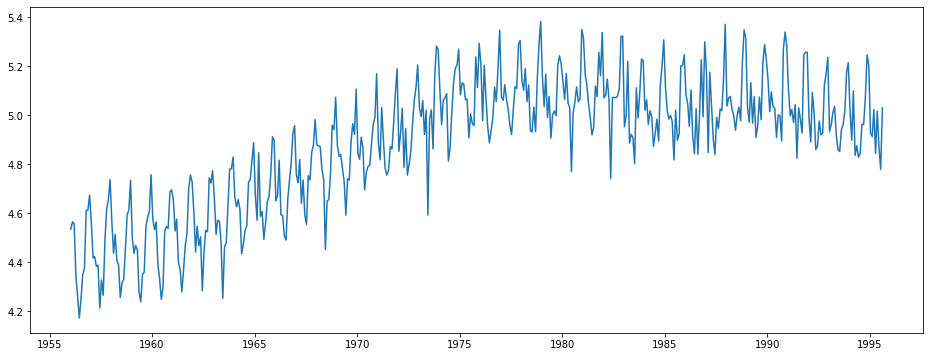

In [10]:
plt.plot(ts_log)

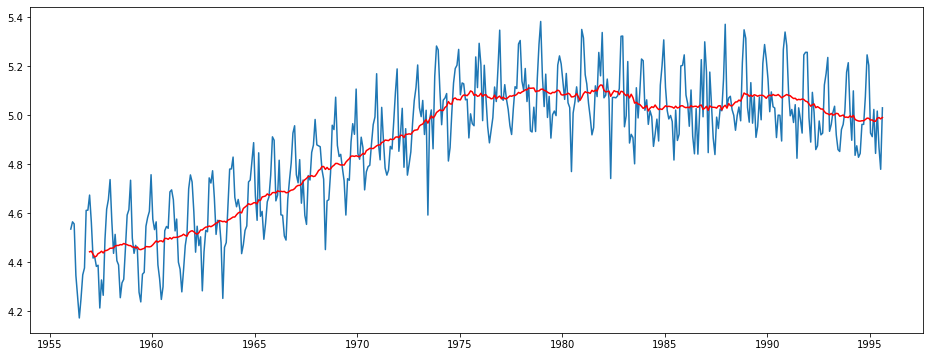

In [11]:
movingAvg = ts_log.rolling(window=12).mean()
movingStd = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAvg, color='red')
#plt.plot(movingStd, color = 'green')

In [12]:
ts_log_mv_diff = ts_log - movingAvg
print(ts_log_mv_diff.head())

ts_log_mv_diff.dropna(inplace=True)
print(ts_log_mv_diff.head())

Month
1956-01-15   NaN
1956-02-15   NaN
1956-03-15   NaN
1956-04-15   NaN
1956-05-15   NaN
Name: Monthly beer production in Australia, dtype: float64
Month
1956-12-15    0.231830
1957-01-15    0.118994
1957-02-15   -0.015558
1957-03-15    0.001590
1957-04-15   -0.041908
Name: Monthly beer production in Australia, dtype: float64


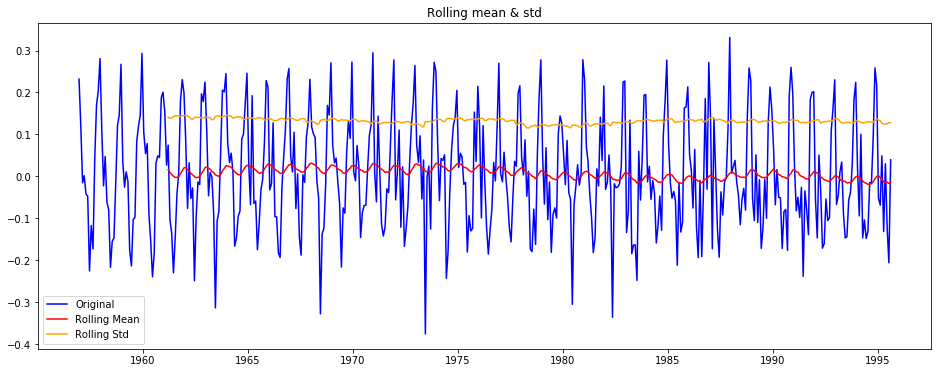

Result of Dickey - Fuller
Test Statistic                 -3.432559
p-value                         0.009898
#Legs Used                     13.000000
Number of Observation Used    451.000000
Critical Value (1%)            -3.444933
Critical Value (5%)            -2.867970
Critical Value (10%)           -2.570195
dtype: float64


In [13]:
test_stationarity(ts_log_mv_diff)

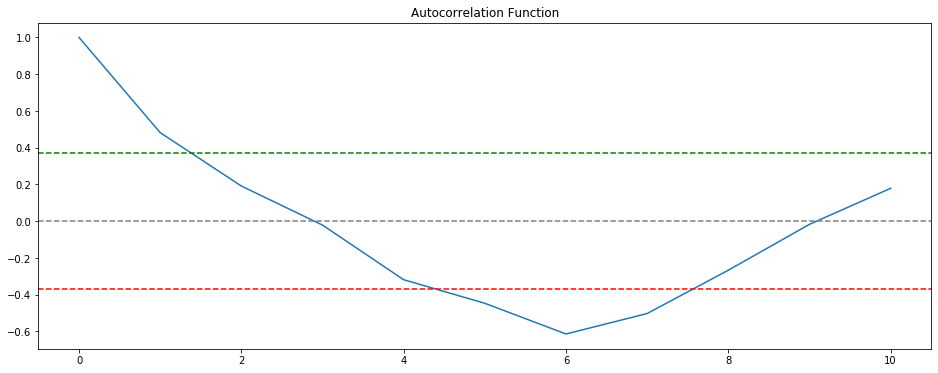

In [14]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='red')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='green')
plt.title('Autocorrelation Function')
plt.show()

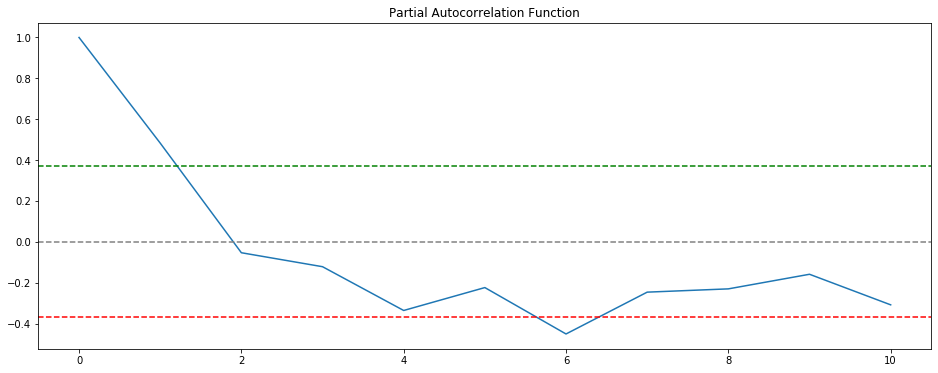

In [15]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='red')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='green')
plt.title('Partial Autocorrelation Function')
plt.show()

Text(0.5, 1.0, 'RSS: -10.6097')

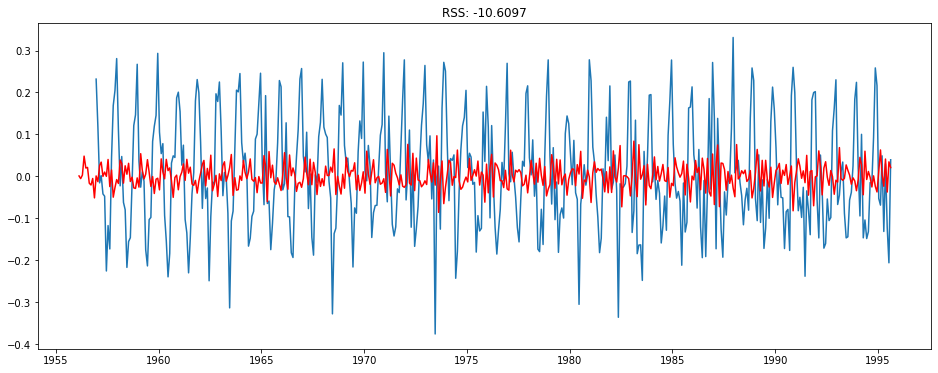

In [16]:
model = ARIMA(ts_log, order=(1,1,0))
result_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum(result_ARIMA.fittedvalues[1] - ts_log_mv_diff**2))

In [17]:
pred_ARIMA_diff = pd.Series(result_ARIMA.fittedvalues, copy=True)
pred_ARIMA_diff.head()

Month
1956-02-15    0.000936
1956-03-15   -0.005458
1956-04-15    0.003012
1956-05-15    0.048189
1956-06-15    0.019847
dtype: float64

In [18]:
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()
pred_ARIMA_diff_cumsum.head()

Month
1956-02-15    0.000936
1956-03-15   -0.004522
1956-04-15   -0.001510
1956-05-15    0.046680
1956-06-15    0.066527
dtype: float64

In [19]:
pred_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_diff_cumsum, fill_value=0)
pred_ARIMA_log.head()

Month
1956-01-15    4.534748
1956-02-15    4.535684
1956-03-15    4.530226
1956-04-15    4.533238
1956-05-15    4.581428
dtype: float64

Text(0.5, 1.0, 'RMSE: 10633.3726')

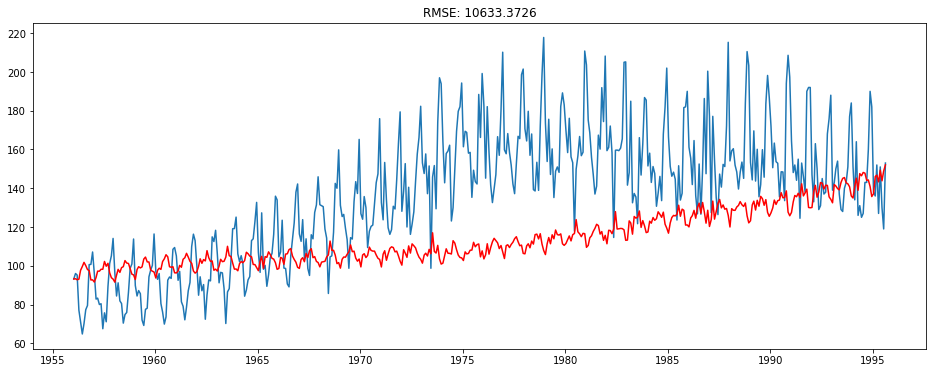

In [20]:
pred_ARIMA = np.exp(pred_ARIMA_log)
plt.plot(ts)
plt.plot(pred_ARIMA, color='red')
plt.title('RMSE: %.4f'%np.sqrt(sum(pred_ARIMA - ts)**2))